In [ ]:
#pip install pmdarima

# CPI State Space Model Using ARIMA Method

[10 year US Government Bond Yields (long-term interest rate)](https://datahub.io/core/bond-yields-us-10y#readme)
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

### Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.The functions of use will are:
- ARIMA
- SARIMAX
- SEASONAL DECOMPOSE
- AUTO CORRELATION AND PARTIAL CORRELATION
- ACF AND PACF PLOT
- ADF FULLER - TEST
- KPSS

**Given the variety of tools, we can provide more accurate and useful predictions.**


In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns

# Statsmodel for statistics
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

# Scientific computation
import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
#
#matplotlib.rcParams['figure.figsize'] = [8, 3]
#rcParams['figure.figsize'] = 18, 5
#rcParams['axes.spines.top'] = True
#rcParams['axes.spines.right'] = True
#rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
#rcParams['lines.linewidth'] = 2.5

%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)
print('Seaborn:', sns.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2
Seaborn: 0.11.2


In [ ]:
# read in cpi data
#month = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data/cpi_avg_price_data.csv', parse_dates=['Year'], index_col='Year')

In [8]:
month = pd.read_csv('/Users/jasonrobinson/Documents/Projects/time_series_analysis/data/cpi_state_space.csv',parse_dates=['Year'], index_col='Year')
print(month.shape)
# Remove leaky data
month = month[:-1]
month.head()

(75, 13)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,CPI
Year,,,,,,,,,,,,,
1948-01-01,23.7,23.5,23.4,23.8,23.9,24.1,24.4,24.5,24.5,24.4,24.2,24.1,288.5
1949-01-01,24.0,23.8,23.8,23.9,23.8,23.9,23.7,23.8,23.9,23.7,23.8,23.6,285.7
1950-01-01,23.5,23.5,23.6,23.6,23.7,23.8,24.1,24.3,24.4,24.6,24.7,25.0,288.8
1951-01-01,25.4,25.7,25.8,25.8,25.9,25.9,25.9,25.9,26.1,26.2,26.4,26.5,311.5
1952-01-01,26.5,26.3,26.3,26.4,26.4,26.5,26.7,26.7,26.7,26.7,26.7,26.7,318.6


In [9]:
month = month[['CPI']]

In [10]:
month

,CPI
Year,
1948-01-01,288.5
1949-01-01,285.7
1950-01-01,288.8
1951-01-01,311.5
1952-01-01,318.6
...,...
2017-01-01,2941.4
2018-01-01,3013.3
2019-01-01,3067.9


### Preprocessing

**Task**: Either use univariate or multivariate time series analysis.
If multivariate incorporate method to sum or average annual value for specific year

In [11]:
# Sum each row for univariate analysis
#month['CPI'] = month.sum(axis=1)
#month['CPI'] 

In [32]:
month.describe()

,CPI
count,74.000000
mean,1385.637838
std,971.641076
min,285.700000
25%,392.200000
50%,1268.700000
75%,2195.250000
max,3251.600000



### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

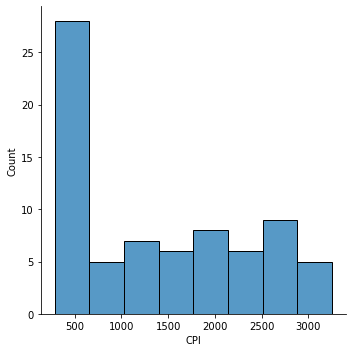

In [12]:
# Long right skewed distribution
sns.displot(data=month['CPI']);

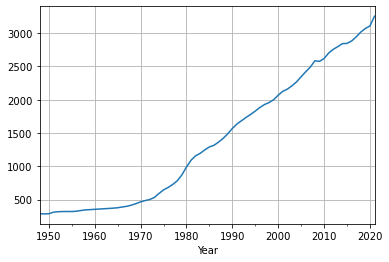

In [13]:
month['CPI'].plot(x='CPI',grid=True);

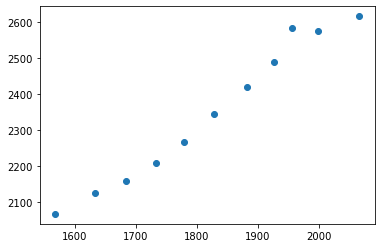

In [14]:
# Comparing 2 previous decades
plt.scatter(month['CPI']['1990':'2000'], month['CPI']['2000':'2010']);

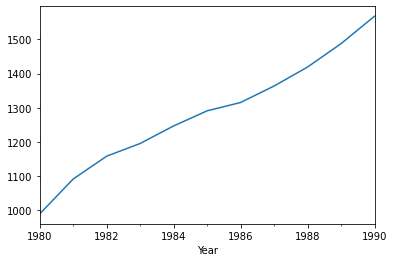

In [15]:
month['CPI']['1980':'1990'].plot();


### Test for Stationarity

To be capable of applying an **ARIMA** method, we will first need to add stationarity. First let's confirm that our time series is not stationary. A few methods exist for this, but we will use the **KPSS** method.



In [16]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month['CPI'])

(0.4312793465751795, True)

In [33]:
from statsmodels.tsa.stattools import adfuller
# We acquire greater results through adfuller

def adf_test(month):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(month['CPI'], autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    

    
adf_test(month)

Results of Dickey-Fuller Test:
Test Statistic                  2.369475
p-value                         0.998995
#Lags Used                      1.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month['CPI'], regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
    
kpss_test(month)

In [ ]:
# Reject the null hypothesis - test statistic actual pvalue smaller
sm.tsa.stattools.kpss(month['CPI'], regression='ct')

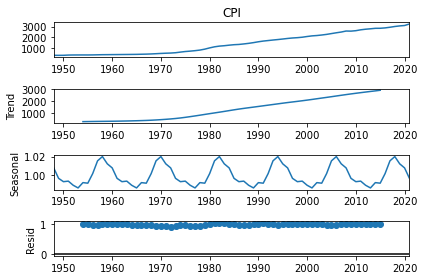

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

seas_dcomp = seasonal_decompose(month['CPI'],period=12,model='multiplicative')
seas_dcomp.plot();


### Make Series Stationary Using Log Transform


In [35]:
#Transform the data from non-statinary to stationary
# First differencing
month_log = np.log(month['CPI'])
month_diff = month_log.diff().dropna()

In [36]:
# Check for stationarity
result = adfuller(month_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -2.253457
p-value: 0.187418
Critical values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


In [37]:
result_kpss_ct_log=kpss(month_diff,regression="ct")
print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
print('p-value: %f' %result_kpss_ct_log[1])
print('Critical values:')
for key, value in result_kpss_ct_log[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.130000
p-value: 0.081766
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


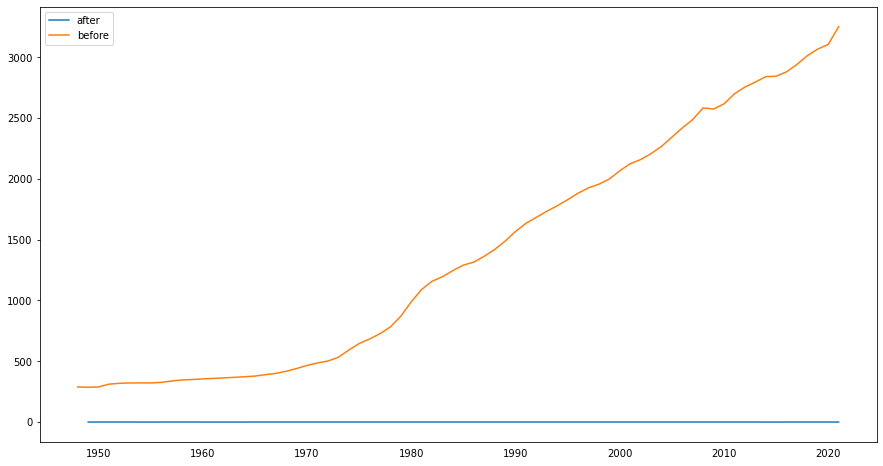

In [38]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month['CPI'],label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()

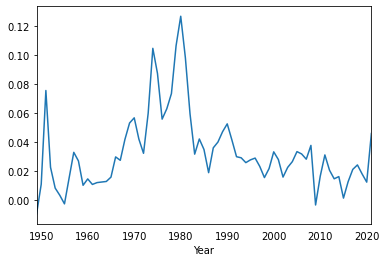

In [39]:
# Closer display
month_diff.plot()
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom='CPI')
plt.show();


### ACF/PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [40]:
# Autocorrelation
acf_month = acf(month['CPI'])
acf_month

array([ 1.        ,  0.96462686,  0.93087422,  0.89605767,  0.86097073,
        0.82591324,  0.7905578 ,  0.75421508,  0.71597011,  0.6771392 ,
        0.63769855,  0.5979538 ,  0.55862121,  0.51879962,  0.47694696,
        0.43602383,  0.39533848,  0.35511115,  0.31548499,  0.27615422,
        0.23692476,  0.19745469,  0.15850187,  0.12045099,  0.08255924,
        0.0444266 ,  0.00671071, -0.02989925, -0.06554118, -0.10054258,
       -0.13461162, -0.16757414, -0.19843329, -0.22623966, -0.25147202,
       -0.27493632, -0.29718644, -0.31871012, -0.33914181, -0.35854139,
       -0.37689689])

Nice, we can definitely tell the difference, but let's see if we can do better

Most important is ?

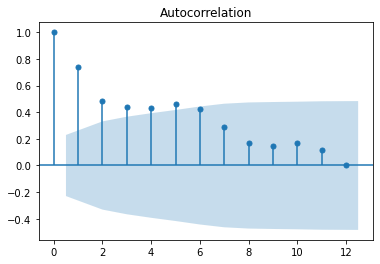

In [46]:
plot_acf(month_diff, lags=12);

In [47]:
# Partial autocorrelation
pacf_month = pacf(month_diff)
pacf_month

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 40 must be < 36.

In [43]:
plot_pacf(pacf_month, lags=12);

NameError: name 'pacf_month' is not defined

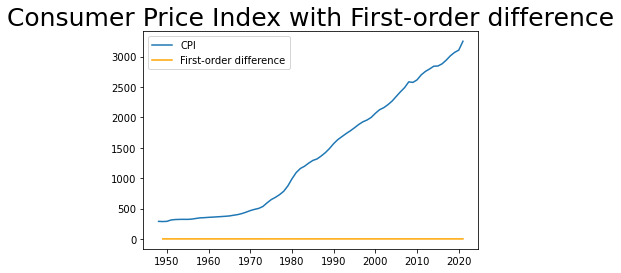

In [44]:
# Visualize our plots
plt.title('Consumer Price Index with First-order difference', size=25)
plt.plot(month['CPI'], label='CPI')
plt.plot(month_diff, label='First-order difference', color='orange')
plt.legend();


## Auto-ARIMA

In [49]:
from pmdarima import auto_arima

model = auto_arima(month['CPI'],start_p=0, d=0, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 25 )

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=733.461, Time=2.30 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=846.505, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=731.213, Time=0.48 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=736.941, Time=0.46 sec
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,0,1)(1,1,0)[24] intercept   : AIC=503.322, Time=1.07 sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=505.322, Time=0.31 sec
 ARIMA(1,0,1)(2,1,0)[24] intercept   : AIC=502.832, Time=2.60 sec
 ARIMA(1,0,1)(3,1,0)[24] intercept   : AIC=507.487, Time=5.81 sec
 ARIMA(1,0,1)(2,1,1)[24] intercept   : AIC=inf, Time=3.55

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   74
Model:             SARIMAX(2, 0, 1)x(1, 1, [], 24)   Log Likelihood                -242.477
Date:                             Sat, 23 Jul 2022   AIC                            496.955
Time:                                     01:38:36   BIC                            508.427
Sample:                                          0   HQIC                           501.323
                                              - 74                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4498      5.383      0.641      0.522      -7.100      13.999
ar.L1          1.8724      0.159     11.747      0.000       1.560       2.185
ar.L2         -0.8729      0.162     -5.383      0.000      -1.191      -0.555
ma.L1         -0.4070      0.312     -1.306      0.191      -1.018       0.204
ar.S.L24      -0.5013      0.274     -1.833      0.067      -1.037       0.035
sigma2       758.5680    146.208      5.188      0.000     472.005    1045.131
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                11.68
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               3.02   Skew:                             0.10
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
prediction = pd.DataFrame(model.predict(n_periods = 30),index=test.index)
prediction.columns = ['CPI']
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('FirstPred.jpg')
plt.show()

NameError: name 'train' is not defined

<Figure size 576x360 with 0 Axes>


## SARIMAX

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the second P,D,Q,m to account for seasonality. Placing our model in _state space_ form

In [ ]:
model=sm.tsa.statespace.SARIMAX(month_diff,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

In [ ]:
month['forecast']=results.predict(start=90,end=103,dynamic=True)
month[[month_diff,'forecast']].plot(figsize=(12,8))

In [52]:
# Split data into train / test sets
train = month['CPI'].iloc[:len(month['CPI'])]
test = month['CPI'].iloc[len(month['CPI']):] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train,
                order=(1, 0, 0),
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=True,
                mle_regression=True)
  
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80265D+03    |proj g|=  3.50436D+03

At iterate    5    f=  1.59884D+01    |proj g|=  2.10535D+01

At iterate   10    f=  6.39092D+00    |proj g|=  8.67940D-01

At iterate   15    f=  5.26311D+00    |proj g|=  4.73833D-02

At iterate   20    f=  5.10728D+00    |proj g|=  1.92476D-02

At iterate   25    f=  5.09858D+00    |proj g|=  1.43847D-03

At iterate   30    f=  5.09593D+00    |proj g|=  8.15289D-03

At iterate   35    f=  5.09508D+00    |proj g|=  5.58152D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  CPI   No. Observations:                   74
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -377.036
Date:                              Sat, 23 Jul 2022   AIC                            762.071
Time:                                      01:43:59   BIC                            771.288
Sample:                                  01-01-1948   HQIC                           765.748
                                       - 01-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.001    683.452      0.000       0.997       1.002
ar.S.L12       0.8005      0.189      4.236      0.000       0.430       1.171
ma.S.L12      -0.2183      0.269     -0.812      0.417      -0.745       0.308
sigma2      1228.6411    163.796      7.501      0.000     907.606    1549.676
===================================================================================
Ljung-Box (L1) (Q):                   9.88   Jarque-Bera (JB):                78.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              17.95   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ValueError: zero-size array to reduction operation fmin which has no identity

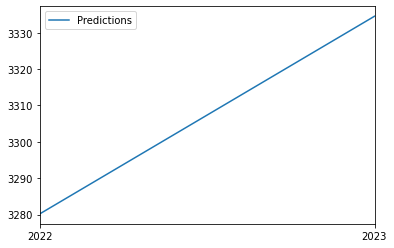

In [53]:
start = len(train)
end = len(train) + len(test) + 1   #10 years into the future
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

## External code (COME BACK BUT NOT RELEVANT)

In [ ]:
import plotly.graph_objects as go

In [ ]:
#month['Cpi'] = np.where(month['Cpi'] > month['Cpi'].shift(1), 1, -1)


#fig = go.Figure(data=go.Scatter(
#                    y=np.exp(month['Cpi'].cumsum()),
#                    x=month.index,
#                    name="Cpi")
#               )
fig.add_trace(
        go.Scatter(
            y=np.log(month['CPI']),
            x=month.index,
            name="Predictions")
    )
fig.update_layout(title=dict(text="Consumer Price Index",font=dict(size=18)),
                 legend=dict(font=dict(size=10)),
                  width=600,
                  height=500)

fig.update_xaxes(tickfont=dict(size=15, color="#434"))
fig.update_yaxes(tickfont=dict(size=15, color="#434"))

fig.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
# Mse - always non-negative and values close to zero are better
# Incorporates both the variance of the estimator and its bias.

rmse(test, predictions)
mean_squared_error(test, predictions)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88930D+00    |proj g|=  2.09608D+00

At iterate    5    f= -1.89462D+00    |proj g|=  3.32313D+00

At iterate   10    f= -1.94958D+00    |proj g|=  9.56586D-02


 This problem is unconstrained.



At iterate   15    f= -1.95003D+00    |proj g|=  4.41081D-02

At iterate   20    f= -1.95679D+00    |proj g|=  6.65171D-01

At iterate   25    f= -1.95823D+00    |proj g|=  6.15386D-01

At iterate   30    f= -1.97932D+00    |proj g|=  7.78332D-01

At iterate   35    f= -1.98381D+00    |proj g|=  4.10864D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     73      1     0     0   2.112D-01  -1.985D+00
  F =  -1.9849281894524402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


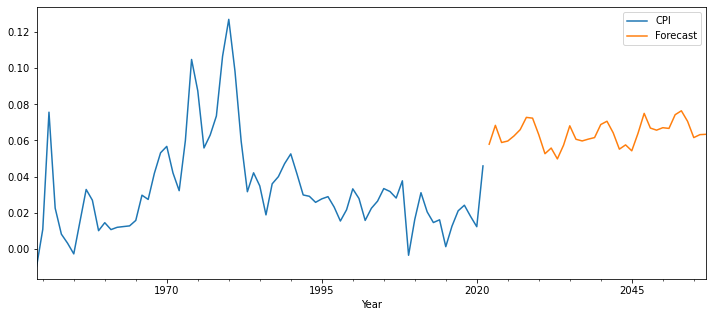

In [54]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);


In [ ]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(month, test_size=len(test),  
#                              random_state=42)

In [ ]:
start = len(month_diff)
end = len(month['CPI']) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);


### Alternate version


In [ ]:
mod = sm.tsa.statespace.SARIMAX(month_diff, order=(2,1,1), seasonal_order=(1,1,0,100), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

In [ ]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci

### The credible intervals?? How they expand over future, etc.